In [1]:
import os
import numpy as np
import h5py as h5
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime
import argparse
import pdb
from functools import partial
from copy import deepcopy
from tqdm.notebook import tqdm
import pickle as pkl

import jax
import jax.numpy as jnp
import equinox as eqx
import optax

import samplers
import models
import main
import main_utils
import opto
import ih_paper_plot_utils

%matplotlib inline

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
base_folder = './ih_paper_reprod/main_paper_is8_ih1_pt2'

# Section 3: Induction head emergence and diversity

## Figure 3a

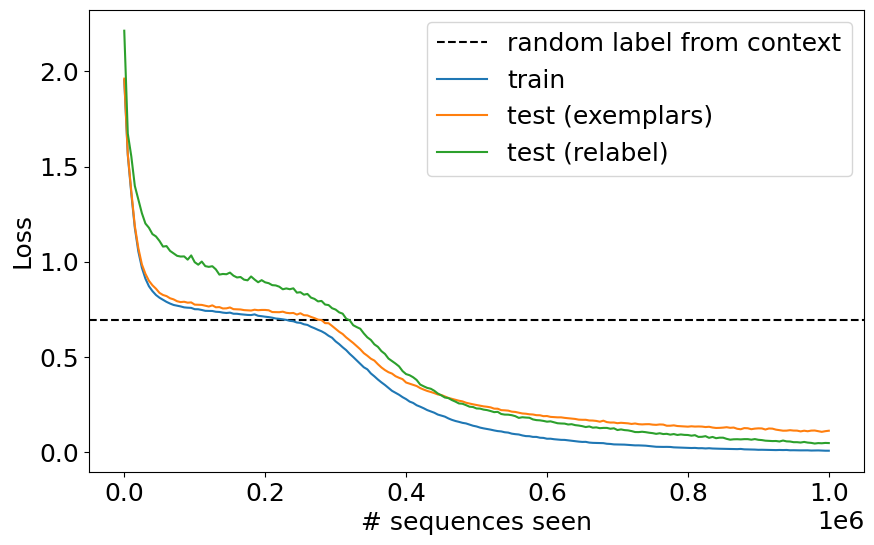

In [4]:
f = h5.File(f'{base_folder}/omniglot50_rl5/log.h5', 'r')
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10,6)
metric='loss'
axs.axhline(np.log(2), c='k', ls='--', label='random label from context')
axs.plot(f['eval_iter'][:], np.mean(f['fsl_train'][metric][:], axis=1), label='train')
axs.plot(f['eval_iter'][:], np.mean(f['fsl_test_class'][metric][:], axis=1), label='test (exemplars)')
axs.plot(f['eval_iter'][:], np.mean(f['fsl_val_rl'][metric][:], axis=1), label='test (relabel)')
axs.legend()
# axs.set_title('Various losses over time')
axs.set_ylabel("Loss")
axs.set_xlabel("# sequences seen")
axs.get_ylim()
fig.savefig(f'{base_folder}/figures/figure_3a.pdf')
f.close()

## Figure 3b

### Create all sequences in training dataset
We use this for various analyses in Section 3

In [5]:
opts = main_utils.get_opts_from_json_file(f'{base_folder}/omniglot50_rl5/config.json')

data = main_utils.get_data_from_opts(opts)
print(data.shape)

splits = main_utils.get_splits_from_opts(opts, data.shape)
model = main_utils.get_model_from_opts(opts, (data.shape[-1], ))
fwd_fn_from_train = opto.make_fn_from_opts(opts)

(1623, 5, 512)
data shape 0: 1623 class split: [50, 1473, 100]
Splitting fs relabelings with train: 8, val: 2, test: 0


In [6]:
n_classes = opts.class_split[0]
temp = np.broadcast_to(splits['class']['train'], (n_classes, n_classes))
all_pairs = jnp.vstack([temp.T.reshape(-1), temp.reshape(-1)]).T
class_pairs = all_pairs[all_pairs[:, 0] != all_pairs[:, 1]]

### Get all label pairs
raw_labels = splits['relabeling']['train']
label_pairs = jnp.concatenate([raw_labels, raw_labels[:, ::-1]], axis=0)

### Make product of class pairs and label pairs
total = class_pairs.shape[0]*label_pairs.shape[0]
all_class_pairs = jnp.broadcast_to(class_pairs, (label_pairs.shape[0], *class_pairs.shape)).reshape(total, class_pairs.shape[1])
all_label_pairs = jnp.broadcast_to(label_pairs[:, None, :], (label_pairs.shape[0], class_pairs.shape[0], label_pairs.shape[1])).reshape(total, label_pairs.shape[1])

duplicate = lambda x: jnp.concatenate([jnp.concatenate([x, x[:, 0:1]], axis=1), jnp.concatenate([x, x[:, 1:2]], axis=1)], axis=0)

##### Load data
all_data = dict()
all_data['class_pairs'] = duplicate(all_class_pairs)
all_data['examples'] = data[all_data['class_pairs'], 0]
all_data['labels'] = duplicate(all_label_pairs)
all_data['correct_ind'] = jnp.concatenate([jnp.zeros(all_class_pairs.shape[0]), jnp.ones(all_class_pairs.shape[0])]).astype(int)
##### done loading data

all_data['correct_ind'].shape

(78400,)

Dataset sizes matches what we would expect, given the calculation in Appendix C.

### Get induction strengths for each head through time

In [7]:
# Make a forward fn that returns the activations we care about

# We use this construction to allow for optogenetic based progress measures later
# (e.g., appendix figure 10, later in the notebook)
parser = argparse.ArgumentParser()
opto.add_args_to_parser(parser)
default_opto_opts = parser.parse_args(args=[])

# In this case, since we haven't specified any options,
# this will just be the standard model forward
model_fn = main.make_batched_fn(
                ih_paper_plot_utils.make_forward_fn(default_opto_opts, 
                                                    default_fn=fwd_fn_from_train), 
                batch_size=1024) # Could mess around with this to speed up

opt_state = main_utils.get_optimizer_from_opts(opts).init(eqx.filter(model, eqx.is_array))

ckpt_fmt = {'iter': -1, 
            'seeds': {'eval_model_seed': jax.random.PRNGKey(0),
                      'train_data_seed': jax.random.PRNGKey(0),
                      'train_model_seed': jax.random.PRNGKey(0)}, 
            'opt_state': opt_state,
            'model': model}

In [8]:
# Figure out which indices we'd like to plot, allowing for downsampling (for speed)
num_ckpts_to_plot = 100

filenames = sorted(os.listdir(f'{base_folder}/omniglot50_rl5/checkpoints/'))
iters = np.array([int(cn.split('.')[0]) for cn in filenames])

inds_to_plot = ih_paper_plot_utils.get_closest_inds(np.linspace(iters[0], iters[-1], num_ckpts_to_plot), iters)

In [9]:
info = dict(iters=[], loss=[], prob=[], activations=[])
for ind in tqdm(inds_to_plot):
    ckpt_fname = f'{base_folder}/omniglot50_rl5/checkpoints/{filenames[ind]}'
    ckpt = eqx.tree_deserialise_leaves(ckpt_fname, ckpt_fmt)
    results = model_fn(ckpt['model'], all_data['examples'], all_data['labels'], key=jax.random.PRNGKey(0))
    info['activations'].append(results['activations'][:, 1, :, -1, :])
    info['loss'].append(results['loss'])
    info['prob'].append(results['prob'])
    info['iters'].append(iters[ind])

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/singha/miniconda3/envs/microformer/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:322: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


/var/folders/58/_3hqdwzx443018vk2l47vwdr0000gn/T/ipykernel_70440/4016934352.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Dark2')(np.arange(8))


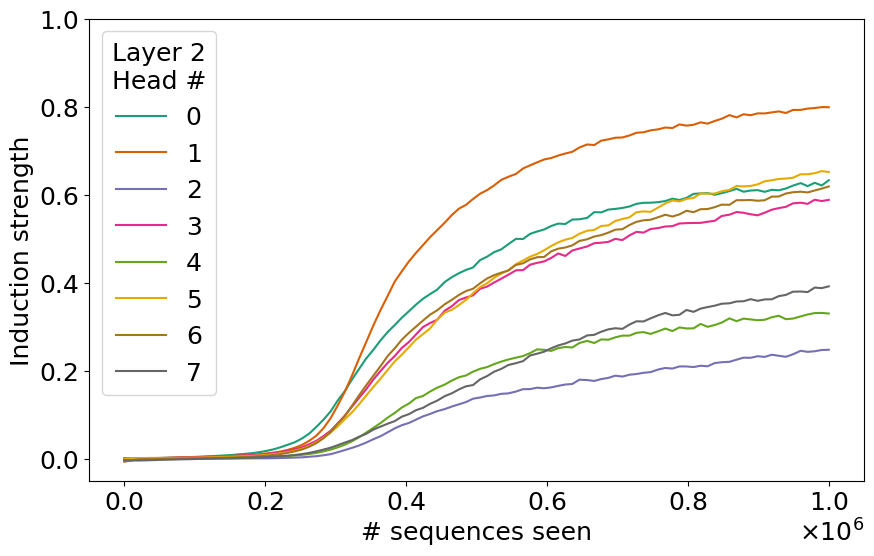

In [10]:
matplotlib.rcParams.update({'font.size': 18})
# Time x bs x num_heads x context length
activations = jnp.stack(info['activations'])
# Flip to context length x num_heads x bs x time
activations = jnp.transpose(activations, (3,2,1,0))

fig, axs = plt.subplots(1,1)
fig.set_size_inches(10,6)
# axs.set_title('Layer 2 "induction strength" over time')
# axs.set_ylabel("Attention delta of correct over\n incorrect token")
axs.set_ylabel("Induction strength")
axs.set_xlabel("# sequences seen")

colors = plt.cm.get_cmap('Dark2')(np.arange(8))

final_strengths = []
for h in range(activations.shape[1]):
    correct_activations = activations[2*all_data['correct_ind']+1, h, np.arange(activations.shape[2]), :]
    incorrect_activations = activations[2*(1-all_data['correct_ind'])+1, h, np.arange(activations.shape[2]), :]
    axs.plot(info['iters'], np.mean(correct_activations-incorrect_activations, axis=0), color=colors[h], label=h)
    final_strengths.append(np.mean(correct_activations-incorrect_activations, axis=0)[-1])

# box = axs.get_position()
# axs.set_position([box.x0, box.y0, box.width * 0.9, box.height])
# axs.legend(title='Head #', loc='center left', bbox_to_anchor=(1, 0.5))
axs.legend(title='Layer 2\nHead #', loc='upper left')

ih_paper_plot_utils.scientific_notation_ticks(axs, xaxis=True, yaxis=False)

axs.set_ylim(-0.05, 1)
fig.savefig(f'{base_folder}/figures/figure_3b.pdf')

## Figure 4a

In [11]:
final_model = eqx.tree_deserialise_leaves(f'{base_folder}/omniglot50_rl5/checkpoints/{filenames[-1]}', 
                                   ckpt_fmt)['model']

In [12]:
forward_fns = dict()

for l in range(8):
    temp_opts = deepcopy(default_opto_opts)
    temp_opts.opto_ablate_heads = ['1:{}'.format(l)]
    forward_fns['remove_l1h{}'.format(l)] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                                 batch_size=1024)
    
    temp_opts = deepcopy(default_opto_opts)
    temp_opts.opto_ablate_heads = ['1:{}'.format(lay) for lay in range(8) if lay != l]
    forward_fns['only_l1h{}'.format(l)] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                               batch_size=1024)

Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...


In [13]:
forward_fns['orig'] = model_fn

temp_opts = deepcopy(default_opto_opts)
# Ablate all Layer 1 heads, but leave the connection to the next layer in place
# This was used for the result just before Section 3
temp_opts.opto_ablate_heads = ['0:{}'.format(l) for l in range(8)]
temp_opts.opto_preserve_patterns = True
temp_opts.opto_preserve_values = True
forward_fns['no_l0'] = main.make_batched_fn(ih_paper_plot_utils.make_forward_fn(temp_opts, default_fn=fwd_fn_from_train), 
                                                               batch_size=1024)

Opto being used...


In [14]:
all_results_no_act = dict()
for k in tqdm(forward_fns):
    out = forward_fns[k](final_model, all_data['examples'], all_data['labels'], key=jax.random.PRNGKey(0))
    del out['activations']
    all_results_no_act[k] = out

  0%|          | 0/18 [00:00<?, ?it/s]

/Users/singha/miniconda3/envs/microformer/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:322: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(


### Result in Section 3, just before Section 3.1

Layer 1 heads are not contributing to loss at the end of training, accuracy drop is ~0.01%

In [15]:
jnp.mean(all_results_no_act['orig']['acc']), jnp.mean(all_results_no_act['no_l0']['acc']), 

(Array(0.9993112, dtype=float32), Array(0.99834186, dtype=float32))

/var/folders/58/_3hqdwzx443018vk2l47vwdr0000gn/T/ipykernel_70440/2727088273.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Dark2')(np.arange(8))


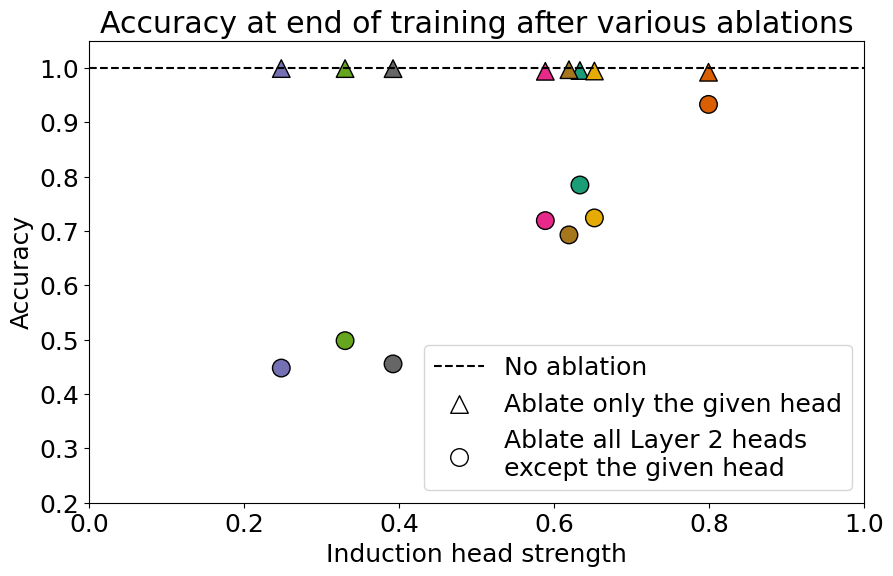

In [16]:
metric = 'acc'
colors = plt.cm.get_cmap('Dark2')(np.arange(8))

matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10,6)
axs.axhline(jnp.mean(all_results_no_act['orig'][metric]), c='k', ls='--', label='No ablation')
axs.scatter(final_strengths, [jnp.mean(all_results_no_act['only_l1h{}'.format(l)][metric]) for l in range(8)], 
            c=colors, marker='o', s=160, edgecolors='k')
axs.scatter(final_strengths, [jnp.mean(all_results_no_act['remove_l1h{}'.format(l)][metric]) for l in range(8)], 
            c=colors, marker='^', s=160, edgecolors='k')
axs.set_xlim(0,1)
axs.set_ylim(0.2, 1.05)

axs.set_xlabel('Induction head strength')
axs.set_ylabel('Accuracy')
axs.set_title("Accuracy at end of training after various ablations")
axs.scatter([-10], [-10], marker='^', c='w', edgecolors='k', s=160, label='Ablate only the given head')
axs.scatter([-10], [-10], marker='o', c='w', edgecolors='k', s=160, label='Ablate all Layer 2 heads\nexcept the given head')

legend = axs.legend()
fig.savefig(f'{base_folder}/figures/figure_4a.pdf')

In [17]:
[float(x) for x in final_strengths]

[0.6334089040756226,
 0.7993404269218445,
 0.24806301295757294,
 0.5887701511383057,
 0.33038777112960815,
 0.6520922780036926,
 0.6192470788955688,
 0.39227789640426636]

### Appendix Figure 13

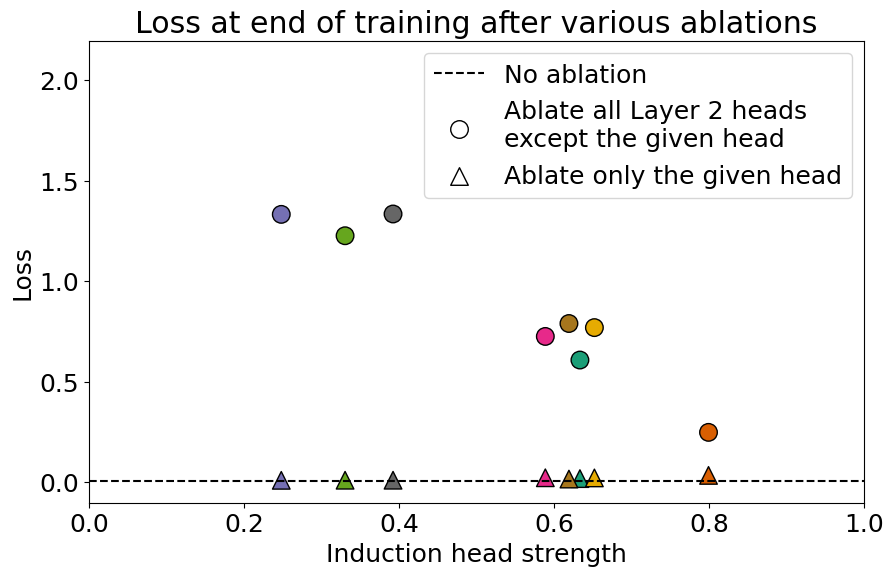

In [18]:
metric = 'loss'
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10,6)
axs.axhline(jnp.mean(all_results_no_act['orig'][metric]), c='k', ls='--', label='No ablation')
axs.scatter(final_strengths, [jnp.mean(all_results_no_act['only_l1h{}'.format(l)][metric]) for l in range(8)], 
            c=colors, marker='o', s=160, edgecolors='k')
axs.scatter(final_strengths, [jnp.mean(all_results_no_act['remove_l1h{}'.format(l)][metric]) for l in range(8)], 
            c=colors, marker='^', s=160, edgecolors='k')
axs.set_xlim(0,1)
axs.set_ylim(-0.10319901696639136, 2.196430138743017)
axs.set_xlabel('Induction head strength')
axs.set_ylabel('Loss')
axs.set_title("Loss at end of training after various ablations")
axs.scatter([-10], [-10], marker='o', c='w', edgecolors='k', s=160, label='Ablate all Layer 2 heads\nexcept the given head')
axs.scatter([-10], [-10], marker='^', c='w', edgecolors='k', s=160, label='Ablate only the given head')
legend = axs.legend()
fig.savefig(f'{base_folder}/figures/appendix_figure_13.pdf')

### Appendix Table 2

In [19]:
mistakes = jnp.sum(jnp.logical_not(all_results_no_act['only_l1h3']['acc']))

for l in range(8):
    comp_acc = all_results_no_act['only_l1h{}'.format(l)]['acc']
    right_not = jnp.logical_and(jnp.logical_not(all_results_no_act['only_l1h3']['acc']), comp_acc)
    print(l, jnp.sum(right_not)/mistakes, jnp.mean(comp_acc))

0 0.6345726 0.78454083
1 0.9452994 0.93283165
2 0.38045305 0.4477551
3 0.0 0.71901786
4 0.4690181 0.49818876
5 0.5864542 0.72399235
6 0.64378774 0.69274235
7 0.23459984 0.45540816


## Figure 4b

/var/folders/58/_3hqdwzx443018vk2l47vwdr0000gn/T/ipykernel_33795/3632928561.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Dark2')(np.arange(8))


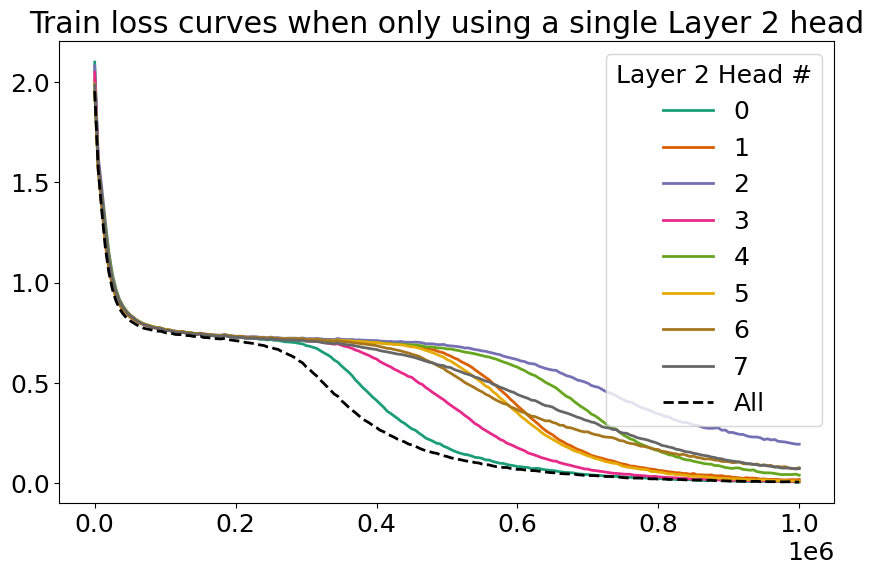

In [4]:
matplotlib.rcParams.update({'font.size': 18})
colors = plt.cm.get_cmap('Dark2')(np.arange(8))

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10,6)

below_thresh = []
for i in range(8):
    f = h5.File(f'{base_folder}/omniglot50_rl5_only_l1h{i}/log.h5', 'r')
    x = f['eval_iter'][:]
    y = np.mean(f['fsl_train']['loss'], axis=1)
    axs.plot(x, y, color=colors[i], label=i, lw=2)
    below_thresh.append(x[np.argmax(y < 0.4*np.log(2))])
    f.close()
f = h5.File(f'{base_folder}/omniglot50_rl5/log.h5', 'r')
axs.plot(f['eval_iter'][:], np.mean(f['fsl_train']['loss'], axis=1), color='k', ls='--', label='All', lw=2)
f.close()

axs.legend(title='Layer 2 Head #')
axs.set_title('Train loss curves when only using a single Layer 2 head')
fig.savefig(f'{base_folder}/figures/figure_4b.pdf')

#### Save the raw losses, accuracies, strengths, and timings as a pkl

In [21]:
to_save = dict()

to_save['strength'] = final_strengths
to_save['acc'] = [jnp.mean(all_results_no_act['only_l1h{}'.format(l)]['acc']) for l in range(8)]
to_save['loss'] = [jnp.mean(all_results_no_act['only_l1h{}'.format(l)]['loss']) for l in range(8)]
to_save['speed'] = below_thresh

with open(f'{base_folder}/figures/per_head_stats.pkl', 'wb') as f:
    pkl.dump(to_save, f)

# Section 4: Three interacting subcircuits

## Figure 5a

This is made using `simple_model_solver.py` in `ih_paper_runs.sh`.

## Figure 5b

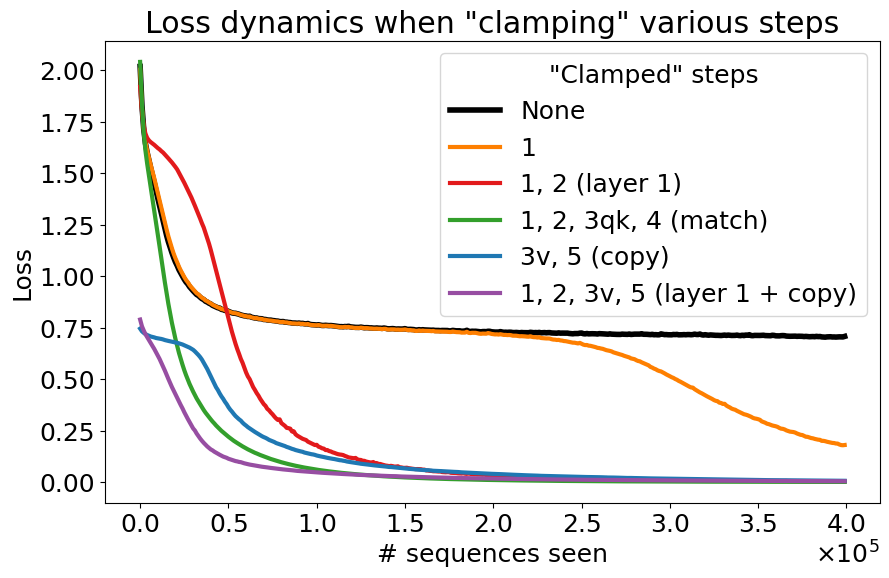

In [5]:
runs = {'None': 'omniglot50_rl5_noclamp',
        '1': 'omniglot50_rl5_perfect_prev_tok_attn_single',
        '1, 2 (layer 1)': 'omniglot50_rl5_perfect_l1',
        '1, 2, 3qk, 4 (match)': 'omniglot50_rl5_perfect_match',
        '3v, 5 (copy)': 'omniglot50_rl5_perfect_copy',
        '1, 2, 3v, 5 (layer 1 + copy)': 'omniglot50_rl5_perfect_l1_and_copy'}

colors = np.array([[0,0,0], [255,127,0], [227,26,28], [51,160,44], [31,120,180], [152,78,163]])/256
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10,6)
for i, r in enumerate(runs):
    f = h5.File(f'{base_folder}/{runs[r]}/log.h5', 'r')
    mask = f['eval_iter'][:] < 4e5
    if r == 'None':
        axs.plot(f['eval_iter'][:][mask], np.mean(f['fsl_train']['loss'], axis=1)[mask], color=colors[i % len(colors)], label=r, lw=4)
    else:
        axs.plot(f['eval_iter'][:][mask], np.mean(f['fsl_train']['loss'], axis=1)[mask], color=colors[i % len(colors)], label=r, lw=3)
    f.close()
axs.legend(title='"Clamped" steps')
axs.set_xlabel('# sequences seen')
axs.set_ylabel('Loss')
axs.set_title('Loss dynamics when "clamping" various steps')

formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
axs.xaxis.set_major_formatter(formatter)

fig.savefig(f'{base_folder}/figures/figure_5b.pdf')

# Section 5: Data-dependent shifts

## Figure 6

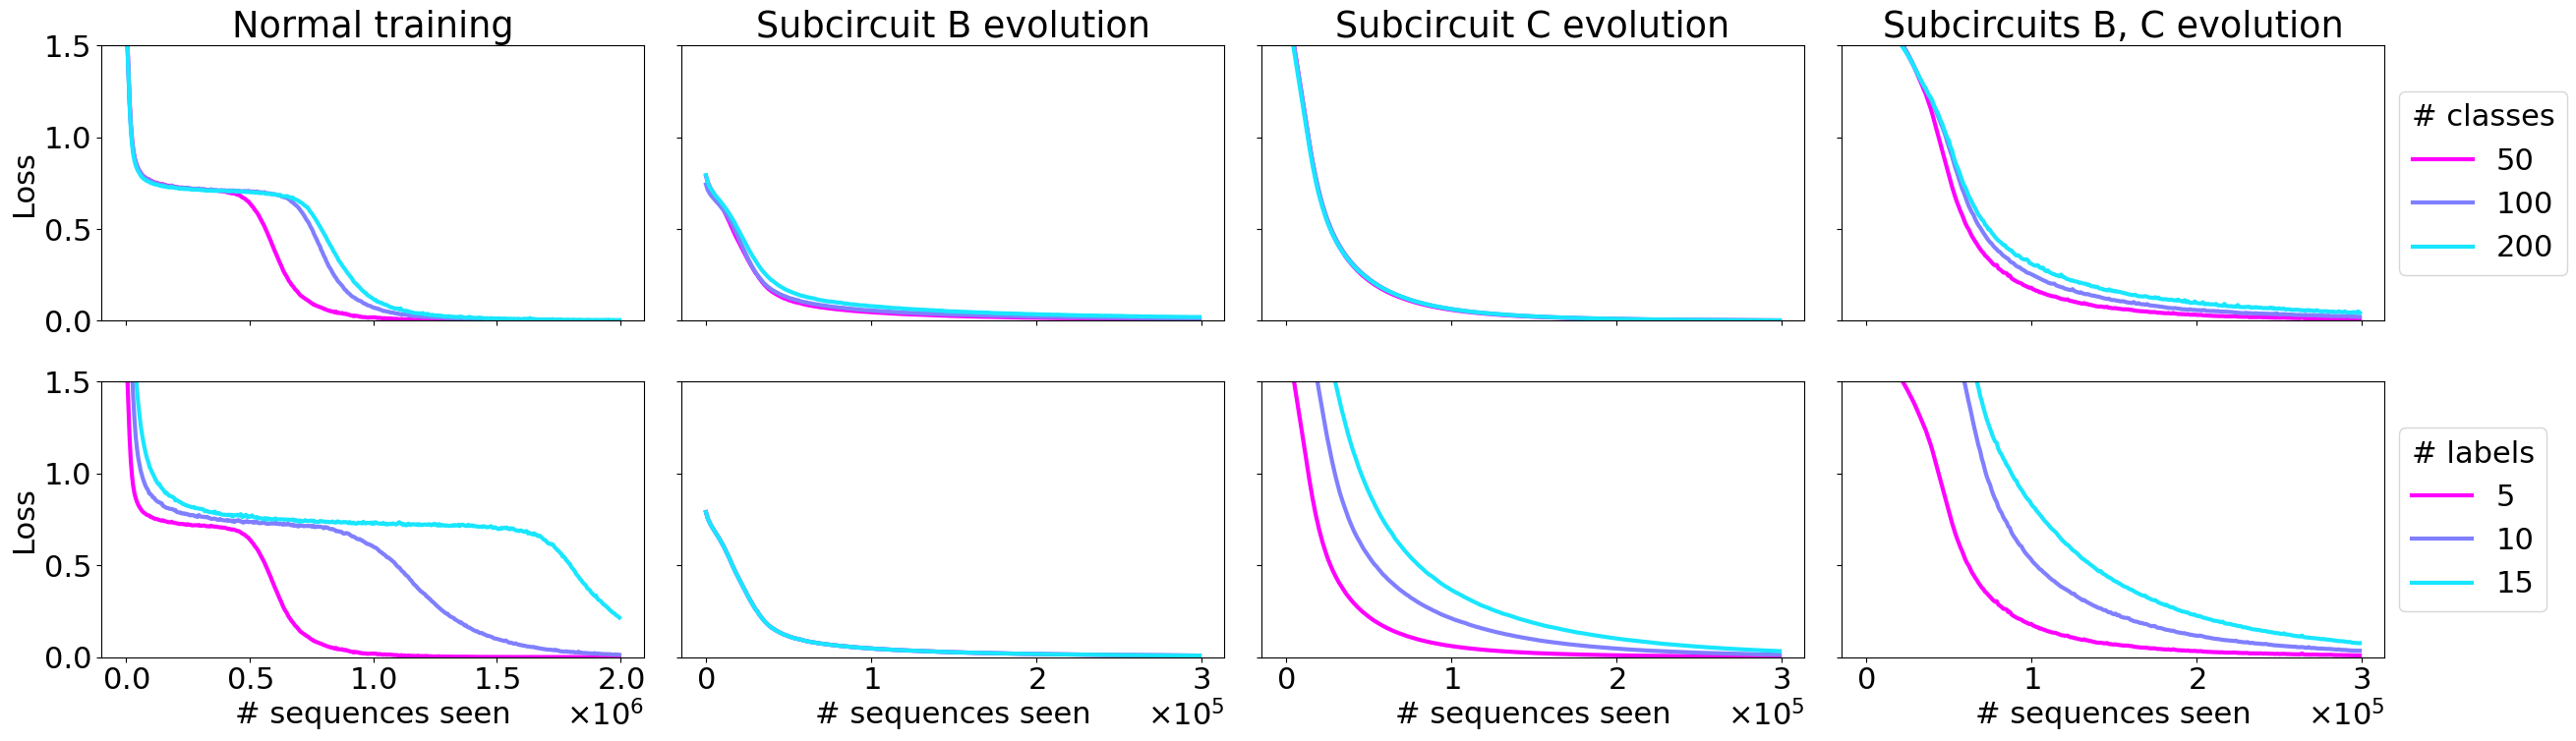

In [23]:
matplotlib.rcParams.update({'font.size': 22})

runs_to_plot = {'Normal training': 'long',
                'Subcircuit B evolution': 'perfect_l1_and_copy', 
                'Subcircuit C evolution': 'perfect_match',
                'Subcircuits B, C evolution': 'perfect_l1',}
colors = plt.get_cmap('cool')([1, 0.5, 0.1])

fig, axs = plt.subplots(2, len(runs_to_plot), sharex='col', sharey=True)
fig.set_size_inches(len(runs_to_plot)*20/3, 8)
for i, r in enumerate(runs_to_plot):
    axs[0, i].set_title(r)
    max_iters = 3e5 if i > 0 else 2e6
    for c, l in enumerate([50, 100, 200]):
        f = h5.File(f'{base_folder}/omniglot{l}_rl5_{runs_to_plot[r]}/log.h5', 'r')
        mask = f['eval_iter'][:] < max_iters
        axs[0, i].plot(f['eval_iter'][:][mask], np.mean(f['fsl_train']['loss'], axis=1)[mask], 
                       color=colors[c], label=l, lw=3)
        f.close()
    for c, l in enumerate([5, 10, 15]):
        f = h5.File(f'{base_folder}/omniglot50_rl{l}_{runs_to_plot[r]}/log.h5', 'r')
        mask = f['eval_iter'][:] < max_iters
        axs[1, i].plot(f['eval_iter'][:][mask], np.mean(f['fsl_train']['loss'], axis=1)[mask], 
                       color=colors[c], label=l, lw=3)
        f.close()
    axs[1, i].set_xlabel("# sequences seen")
    
    formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1,1))
    axs[1, i].xaxis.set_major_formatter(formatter)

axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_ylim(0, 1.5)
axs[1, 0].set_ylabel('Loss')

axs[0, -1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="# classes")
axs[1, -1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="# labels")
plt.tight_layout()
fig.savefig(f'{base_folder}/figures/figure_6.pdf')